# CSV to DXF converter

This script gets a file produced by the ski scanner, which is a CSV type containing information on displacement and width, and transforms it into a dxf file which is the input for the laser cutting machine used at Pomoca.

## CSV file read


[note] For now the file is a manual mock file with manual measurements

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ezdxf as dxf
from ezdxf import recover
from ezdxf.addons.drawing import RenderContext, Frontend
from ezdxf.addons.drawing.matplotlib import MatplotlibBackend

# Reading raw data
df = pd.read_csv("input.csv", sep = ";")
df['W'] = df['W']/2 # Half width to plot profile

# Nominal length
L = 167

# Percentage of smoothness for tip and tail
tipaddp = 0.01 #tip add percentage
tailaddp = 0.005 #tail add percentage

print(df.info())
df.transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   L       85 non-null     int64  
 1   W       85 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.4 KB
None


,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
L,0.0,20.000,40.0,60.00,80.00,100.000,120.00,140.00,160.0,180.000,...,1500.0,1520.0,1540.0,1560.0,1580.0,1600.00,1620.00,1640.0,1660.00,1680.00
W,32.5,38.325,44.1,49.25,52.25,54.325,55.57,56.25,56.5,56.375,...,46.4,47.2,47.8,48.4,49.0,49.68,49.18,48.7,39.95,32.18


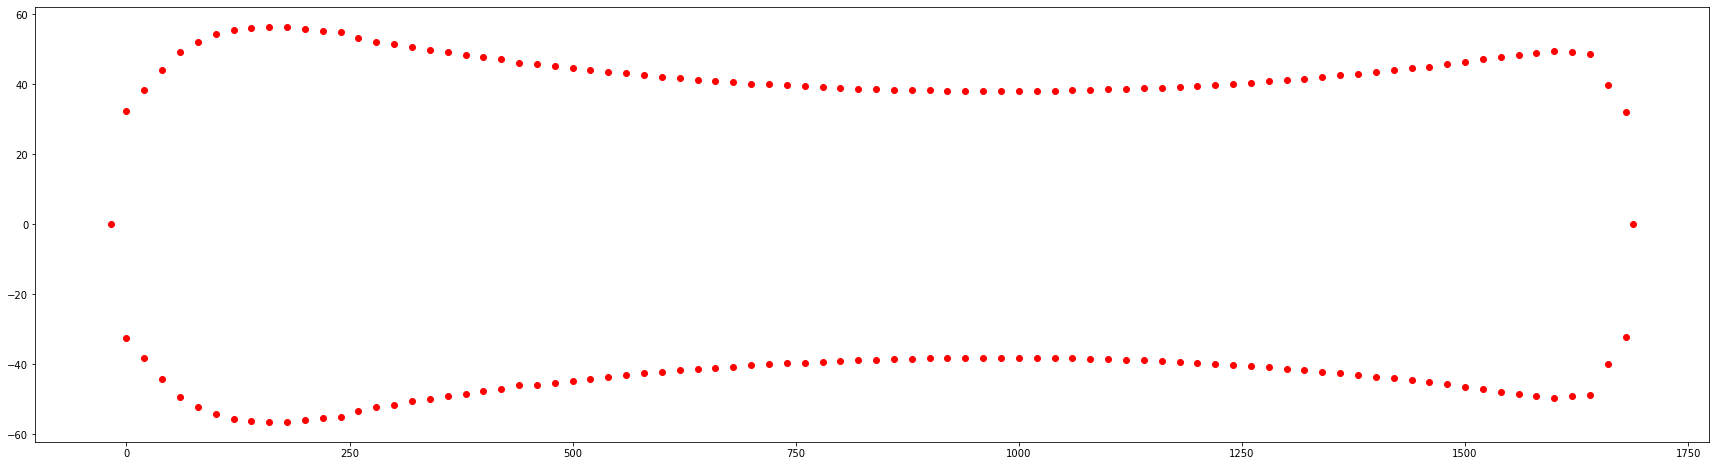

In [53]:
# Plot two sides of the ski

plt.figure(figsize=(30, 8))

df_select = df.to_numpy()
x,y = df_select[:,0],df_select[:,1]
df_select2 = df.to_numpy()
df_select2[:,1] = -df_select[:,1]

maxlength = np.amax(df['L'])
minlength = np.amin(df['L'])
tipadd = np.array([minlength - (maxlength*tipaddp), 0])
tailadd = np.array([maxlength + (maxlength*tailaddp),0])

plt.plot(tipadd[0],tipadd[1], 'ro')
plt.plot(tailadd[0],tailadd[1], 'ro')
plt.plot(df['L'], df['W'], 'ro')
plt.plot(df['L'], -df['W'], 'ro')
plt.show()

In [52]:
np.array(tipadd)

array([-16.8,   0. ])

In [86]:
# Create a new DXF document.
doc = dxf.new(dxfversion='R2010')

# DXF entities (LINE, TEXT, ...) reside in a layout (like modelspace).  
msp = doc.modelspace()

# Convert dataframe to array
df_select = df.to_numpy()
df_select2 = df.to_numpy()
df_select2[:,1] = -df_select[:,1]
extreme_1 = df_select[-1,:]
extreme_2 = df_select2[-1,:]

# Add points to add a flat part to the tail (to be changed with a smoother curve when )
tail = np.concatenate(([np.full(10, df_select2[-1,0])],[np.linspace(extreme_1[1],extreme_2[1],10)]),axis = 0).transpose()
# tail = np.concatenate([df_select[0:-2,:],tail, np.flip(df_select2[0:-2,:], axis=0)])

# df_select3 = np.concatenate([df_select, tail, np.flip(df_select2, axis=0)])
# df_select3 = np.concatenate([tail, np.flip(df_select, axis = 0), [tipadd], df_select2])
# Add entities (spline) to a layout by factory methods: layout.add_...() 
msp.add_spline(df_select)
msp.add_spline(df_select2)
msp.add_spline(tail)

#msp.add_spline(df_select3)

# Save DXF document.
doc.saveas('test.dxf')

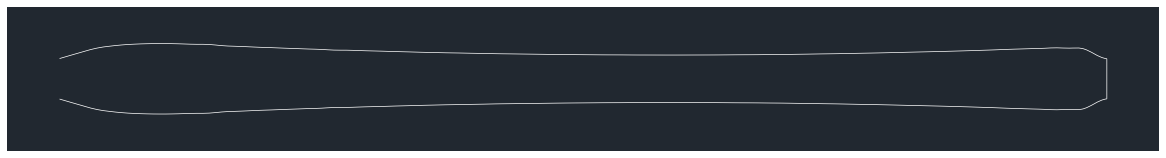

In [88]:
# Safe loading procedure of dxf file(requires ezdxf v0.14):
# The auditor.errors attribute stores severe errors,
# which may raise exceptions when rendering.
try:
    doc, auditor = recover.readfile('test.dxf')
except IOError:
    print(f'Not a DXF file or a generic I/O error.')
    sys.exit(1)
except ezdxf.DXFStructureError:
    print(f'Invalid or corrupted DXF file.')
    sys.exit(2)

# Printing the dxf content
if not auditor.has_errors:
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ctx = RenderContext(doc)
    out = MatplotlibBackend(ax)
    Frontend(ctx, out).draw_layout(doc.modelspace(), finalize=True)
    # Saving dxf content in png image
    #fig.savefig('your.png', dpi=300)